In [57]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import gymnasium as gym


In [58]:
class RandomWalker1D:
    def __init__(self, loc=0.1, sd=0.02):
        self.state = torch.tensor([[0.0], [1.0]], dtype=torch.float)
        self.loc = loc
        self.sd = sd


        pass
    def step(self, a:int):
        noise = torch.normal(self.loc, self.sd, size=(1,), dtype=torch.float)
        if a == 0:
            next_pos = self.state[0, 0] + noise
        elif a == 1:
            next_pos = self.state[0, 0] - noise
        else:
            raise ValueError('a needs to be either integer 1 or 0.')
        terminated = False
        R = -1
        if next_pos > 1: # terminated and no position update
            terminated = True
            R = 1
        elif next_pos < -1: # Punish and no position update
            R = -2
        else:
            self.state[0, 0] = next_pos
            

        return self.state.clone(), R, terminated
    def reset(self):
        self.state = torch.tensor([[0.0], [1.0]], dtype=torch.float)
        return self.state.clone()


In [59]:
class AgentGrad():
    def __init__(self, obs_dim, act_dim, epsilon=0.2, policy='epsilon-greedy'):
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.epsilon = epsilon
        self.policy = policy



    def a_epsilon_greedy(self, q_alla):
        if np.random.rand() < self.epsilon:
            out_a = int(np.random.choice(self.act_dim))
        else:
            out_a = torch.argmax(q_alla).item()
        return out_a
    
    def select_action(self, s):
        if self.policy == 'epsilon-greedy':
            return self.a_epsilon_greedy(s)

        





# Gradient SARSA(1)

In [62]:
obs_dim = 2
act_dim = 2
gamma = 0.98
alpha = 0.01
epsilon=0.1

ag = AgentGrad(obs_dim=obs_dim, act_dim=act_dim, epsilon=epsilon)
env = RandomWalker1D()
w = torch.normal(0.0, 0.001, size=(2, 2), dtype=torch.float, requires_grad=True)

Niters = 5000
all_ts = np.zeros(Niters)

for ni in range(Niters):
    if ni % 1000 == 0:
        print('episode %d, t=%d'% (ni, all_ts[ni-1]))
    t = 0
    terminated = False
    s = env.reset()
    
    with torch.no_grad():
        allq = torch.matmul(w, s)
    a = ag.select_action(allq)

    while (terminated is False) :
        
        allq = torch.matmul(w, s)
        q_now = allq[a, 0]
        s_next, r_next, terminated = env.step(a)
        with torch.no_grad():
            allq_next = torch.matmul(w, s_next)
        
        a_next = ag.select_action(allq_next)
        q_next = allq_next[a_next, 0]

        if terminated:
            td_err = r_next - q_now
        else:
            td_err = r_next + gamma * q_next - q_now

        loss = torch.square(td_err)/2

        loss.backward()
        with torch.no_grad():
            w -= alpha * w.grad
            w.grad = None
        
        s = s_next
        a = a_next
        t += 1
        
    all_ts[ni] = t


episode 0, t=0
episode 1000, t=12
episode 2000, t=14
episode 3000, t=9
episode 4000, t=11


tensor([[ 10.0566,  -8.9446],
        [  9.2750, -10.5297]], requires_grad=True)


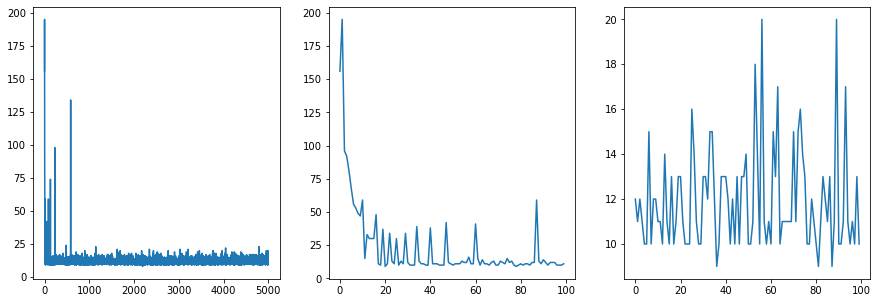

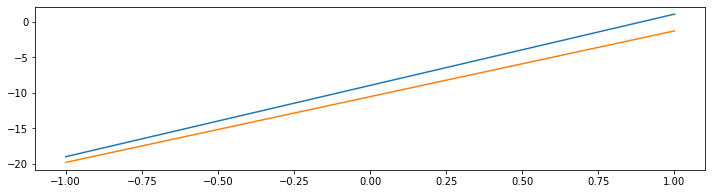

In [63]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(all_ts)
ax[1].plot(all_ts[:100])
ax[2].plot(all_ts[-100:])


xtmp1 = torch.linspace(-1, 1, 1000, dtype=torch.float)
xtmp2 = torch.ones(1000, dtype=torch.float)
x = torch.stack([xtmp1, xtmp2])
with torch.no_grad():
    testq = torch.matmul(w, x)

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(xtmp1, testq[0, :])
ax.plot(xtmp1, testq[1, :])
print(w)

# Gradient SARSA(1) (nn.sequential)

In [64]:
dtype = torch.float
device = torch.device("cpu")
Q_model = torch.nn.Sequential(
    nn.Linear(2, 10),
    nn.ReLU(),
    nn.Linear(10, 2)
)

torch.nn.init.normal_(Q_model[0].weight, 0, 1e-3)
torch.nn.init.normal_(Q_model[2].weight, 0, 1e-3)
print()


In [65]:
obs_dim = 2
act_dim = 2
gamma = 0.98
alpha = 0.01
epsilon=0.1

ag = AgentGrad(obs_dim=obs_dim, act_dim=act_dim, epsilon=epsilon)
env = RandomWalker1D()

Niters = 5000
all_ts = np.zeros(Niters)

for ni in range(Niters):
    if ni % 1000 == 0:
        print('episode %d, t=%d'% (ni, all_ts[ni-1]))
    t = 0
    terminated = False
    s = env.reset()
    with torch.no_grad():
        allq = Q_model(s.squeeze())
        a = ag.select_action(allq)

    Q_model.zero_grad()
    
    while (terminated is False) :
        
        allq = Q_model(s.squeeze())
        q_now = allq[a]

        s_next, r_next, terminated = env.step(a)
        with torch.no_grad():
            allq_next = Q_model(s_next.squeeze())
        
        a_next = ag.select_action(allq_next)
        q_next = allq_next[a_next]

        if terminated:
            td_err = r_next - q_now
        else:
            td_err = r_next + gamma * q_next - q_now

        loss = torch.square(td_err)/2

        loss.backward()
        with torch.no_grad():
            Q_model[0].weight -= Q_model[0].weight.grad * alpha
            Q_model[2].weight -= Q_model[2].weight.grad * alpha
            Q_model.zero_grad()
        
        s = s_next
        a = a_next
        t += 1
        
    all_ts[ni] = t


episode 0, t=0
episode 1000, t=11
episode 2000, t=16
episode 3000, t=15
episode 4000, t=13


Parameter containing:
tensor([[ 2.1876e-04, -4.8863e-04],
        [ 3.0922e-04,  1.9176e-03],
        [-2.1400e-03, -1.0844e-03],
        [-1.3593e-01,  9.5004e-02],
        [-2.8162e+00,  1.9498e+00],
        [ 4.3862e-04, -1.2982e-03],
        [ 6.3266e-04,  7.5325e-04],
        [-3.4240e-04, -1.8084e-05],
        [-1.6015e+00,  1.1088e+00],
        [-2.1497e+00,  1.4936e+00]], requires_grad=True)
Parameter containing:
tensor([[-4.4401e-04,  1.9775e-04, -4.4102e-04, -8.3444e-02, -1.7741e+00,
          9.6276e-04, -1.8207e-03, -6.8342e-04, -1.0641e+00, -1.4211e+00],
        [ 3.2312e-04,  6.9195e-04, -1.2503e-04, -1.1872e-01, -2.3988e+00,
         -3.8578e-04, -3.8278e-04, -7.3892e-04, -1.3096e+00, -1.7752e+00]],
       requires_grad=True)


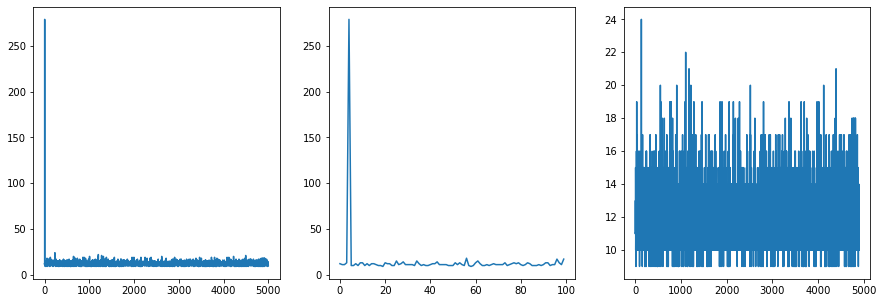

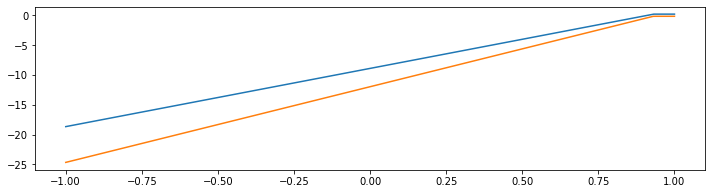

In [67]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(all_ts)
ax[1].plot(all_ts[:100])
ax[2].plot(all_ts[100:])


xtmp1 = torch.linspace(-1, 1, 1000, dtype=torch.float)
xtmp2 = torch.ones(1000, dtype=torch.float)
x = torch.stack([xtmp1, xtmp2])
with torch.no_grad():
    testq = Q_model(x.T)
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(xtmp1, testq[:, 0])
ax.plot(xtmp1, testq[:, 1])
print(Q_model[0].weight)
print(Q_model[2].weight)

# Gradient Sarsa($\lambda$)

In [68]:
dtype = torch.float
device = torch.device("cpu")
Q_model = torch.nn.Sequential(
    nn.Linear(2, 100),
    nn.ReLU(),
    nn.Linear(100, 2)
)

torch.nn.init.normal_(Q_model[0].weight, 0, 1e-3)
torch.nn.init.normal_(Q_model[2].weight, 0, 1e-3)

obs_dim = 2
act_dim = 2
gamma = 0.98
alpha = 0.01
epsilon=0.1
lamb = 0.8

ag = AgentGrad(obs_dim=obs_dim, act_dim=act_dim, epsilon=epsilon)
env = RandomWalker1D()
Niters = 1000
all_ts = np.zeros(Niters)

for ni in range(Niters):
    if ni % 100 == 0:
        print('episode %d, t=%d'% (ni, all_ts[ni-1]))
        # print(Q_model[0].weight, Q_model[2].weight)
    t = 0
    terminated = False
    s = env.reset()
    with torch.no_grad():
        allq = Q_model(s.squeeze())
        a = ag.select_action(allq)

    Q_model.zero_grad()
    z_traces = [
        torch.zeros(Q_model[0].weight.shape, dtype=torch.float),
        torch.zeros(Q_model[2].weight.shape, dtype=torch.float),
    ]
    

    while (terminated is False) :
        
        allq = Q_model(s.squeeze())
        q_now = allq[a]

        s_next, r_next, terminated = env.step(a)
        with torch.no_grad():
            allq_next = Q_model(s_next.squeeze())
        
        a_next = ag.select_action(allq_next)
        q_next = allq_next[a_next]

        if terminated:
            td_err = r_next - q_now
        else:
            td_err = r_next + gamma * q_next - q_now

        loss = torch.square(td_err)/2

        loss.backward()
        with torch.no_grad():
            z_traces[0] = gamma * lamb *z_traces[0] + Q_model[0].weight.grad
            z_traces[1] = gamma * lamb *z_traces[1] + Q_model[2].weight.grad

            Q_model[0].weight -= z_traces[0] * alpha
            Q_model[2].weight -= z_traces[1] * alpha



            Q_model.zero_grad()
        
        s = s_next
        a = a_next
        t += 1
        
    all_ts[ni] = t


episode 0, t=0
episode 100, t=13
episode 200, t=12
episode 300, t=12
episode 400, t=13
episode 500, t=10
episode 600, t=11
episode 700, t=13
episode 800, t=10
episode 900, t=14


Parameter containing:
tensor([[ 7.7735e-02,  1.8786e-02],
        [ 6.6876e-05,  2.0455e-03],
        [-2.3479e-01,  6.5593e-02],
        [-4.3466e-01,  1.1416e-01],
        [ 1.3954e-02,  4.0569e-03],
        [-5.2985e-01,  1.5233e-01],
        [-5.2505e-01,  1.4006e-01],
        [-1.8116e-04, -3.0635e-05],
        [-1.2773e-03,  1.0474e-03],
        [-9.0714e-04, -4.6615e-04],
        [-9.2527e-01,  2.6596e-01],
        [-8.8954e-01,  2.5692e-01],
        [-7.2999e-04, -6.7181e-05],
        [-2.3920e-03,  3.1787e-04],
        [ 4.6838e-02,  1.3241e-02],
        [-8.5393e-04, -2.7509e-04],
        [-1.0922e-04,  5.2795e-04],
        [ 7.2724e-02,  1.7159e-02],
        [-3.4143e-01,  9.0830e-02],
        [ 7.3253e-02,  1.7100e-02],
        [-8.7619e-01,  2.5345e-01],
        [-7.9071e-01,  2.0965e-01],
        [-7.3138e-01,  1.9110e-01],
        [-5.6587e-01,  1.4970e-01],
        [-1.0929e-03, -3.8964e-04],
        [-5.7755e-01,  1.5293e-01],
        [-7.0850e-01,  2.0178e-01],
      

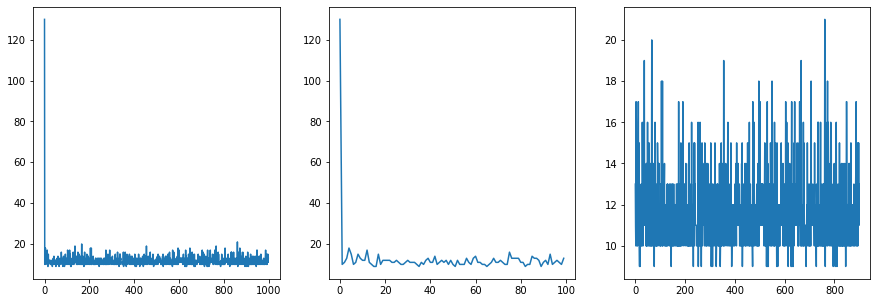

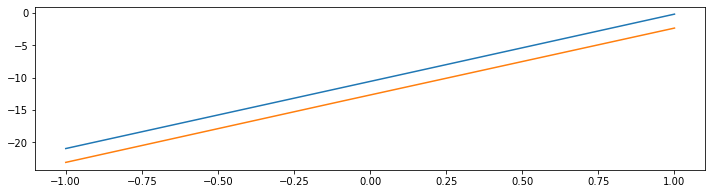

In [69]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(all_ts)
ax[1].plot(all_ts[:100])
ax[2].plot(all_ts[100:])


xtmp1 = torch.linspace(-1, 1, 1000, dtype=torch.float)
xtmp2 = torch.ones(1000, dtype=torch.float)
x = torch.stack([xtmp1, xtmp2])
with torch.no_grad():
    testq = Q_model(x.T)
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(xtmp1, testq[:, 0])
ax.plot(xtmp1, testq[:, 1])
print(Q_model[0].weight)
print(Q_model[2].weight)